## Amazon.com - Employee Access Challenge

When an employee at any company starts work, they first need to obtain the computer access necessary to fulfill their role. This access may allow an employee to read/manipulate resources through various applications or web portals. It is assumed that employees fulfilling the functions of a given role will access the same or similar resources. It is often the case that employees figure out the access they need as they encounter roadblocks during their daily work (e.g. not able to log into a reporting portal). A knowledgeable supervisor then takes time to manually grant the needed access in order to overcome access obstacles. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

There is a considerable amount of data regarding an employee’s role within an organization and the resources to which they have access. Given the data related to current employees and their provisioned access, models can be built that automatically determine access privileges as employees enter and leave roles within a company. These auto-access models seek to minimize the human involvement required to grant or revoke employee access.

### Objective
The objective of this competition is to build a model, learned using historical data, that will determine an employee's access needs, such that manual access transactions (grants and revokes) are minimized as the employee's attributes change over time. The model will take an employee's role information and a resource code and will return whether or not access should be granted.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3338/media/gate.png"/>


* https://www.kaggle.com/competitions/amazon-employee-access-challenge/overview


## Load Library

In [1]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifiers
import lightgbm as lgb

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Plotting functions
import seaborn as sns
from matplotlib import pyplot as plt
#sns.set(style='whitegrid')

## Load Data

In [2]:
base_path = "data/amazon"

train = pd.read_csv(f'{base_path}/train.csv')
test = pd.read_csv(f'{base_path}/test.csv')
submission = pd.read_csv(f'{base_path}/sampleSubmission.csv')

train.shape, test.shape, submission.shape

((32769, 10), (58921, 10), (58921, 2))

## Explore Data

In [3]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
test.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [5]:
submission.head()

,Id,Action
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [6]:
train.describe()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,0.942110,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893,119789.430132
std,0.233539,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413,5784.275516
min,0.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000,117880.000000
25%,1.000000,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000,118232.000000
50%,1.000000,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000,118570.000000
75%,1.000000,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000,119348.000000
max,1.000000,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000,270691.000000


In [7]:
test.describe()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,58921.000000,58921.000000,58921.000000,58921.000000,58921.000000,58921.000000,58921.000000,58921.000000,58921.00000,58921.000000
mean,29461.000000,39383.739482,26691.645050,117028.638041,118316.334091,118858.006721,126358.019993,170455.861425,179278.05896,119707.754264
std,17009.171942,33717.397122,35110.244281,10805.446548,4284.678750,17916.179109,32068.294507,69684.692799,99639.96530,5326.979178
min,1.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.00000,117880.000000
25%,14731.000000,18418.000000,4663.000000,117961.000000,118096.000000,118378.000000,118259.000000,117913.000000,118331.00000,118055.000000
50%,29461.000000,33248.000000,14789.000000,117961.000000,118300.000000,118910.000000,118636.000000,129282.000000,118704.00000,118570.000000
75%,44191.000000,45481.000000,46512.000000,117961.000000,118386.000000,120410.000000,120006.000000,234813.000000,290919.00000,119353.000000
max,58921.000000,312136.000000,311779.000000,311178.000000,194897.000000,277693.000000,311867.000000,311867.000000,308574.00000,270691.000000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                58921 non-null  int64
 1   RESOURCE          58921 non-null  int64
 2   MGR_ID            58921 non-null  int64
 3   ROLE_ROLLUP_1     58921 non-null  int64
 4   ROLE_ROLLUP_2     58921 non-null  int64
 5   ROLE_DEPTNAME     58921 non-null  int64
 6   ROLE_TITLE        58921 non-null  int64
 7   ROLE_FAMILY_DESC  58921 non-null  int64
 8   ROLE_FAMILY       58921 non-null  int64
 9   ROLE_CODE         58921 non-null  int64
dtypes: int64(10)
memory usage: 4.5 MB


In [10]:
set(train)-set(test)

{'ACTION'}

array([[<AxesSubplot:title={'center':'ACTION'}>,
        <AxesSubplot:title={'center':'RESOURCE'}>],
       [<AxesSubplot:title={'center':'MGR_ID'}>,
        <AxesSubplot:title={'center':'ROLE_ROLLUP_1'}>],
       [<AxesSubplot:title={'center':'ROLE_ROLLUP_2'}>,
        <AxesSubplot:title={'center':'ROLE_DEPTNAME'}>],
       [<AxesSubplot:title={'center':'ROLE_TITLE'}>,
        <AxesSubplot:title={'center':'ROLE_FAMILY_DESC'}>],
       [<AxesSubplot:title={'center':'ROLE_FAMILY'}>,
        <AxesSubplot:title={'center':'ROLE_CODE'}>]], dtype=object)

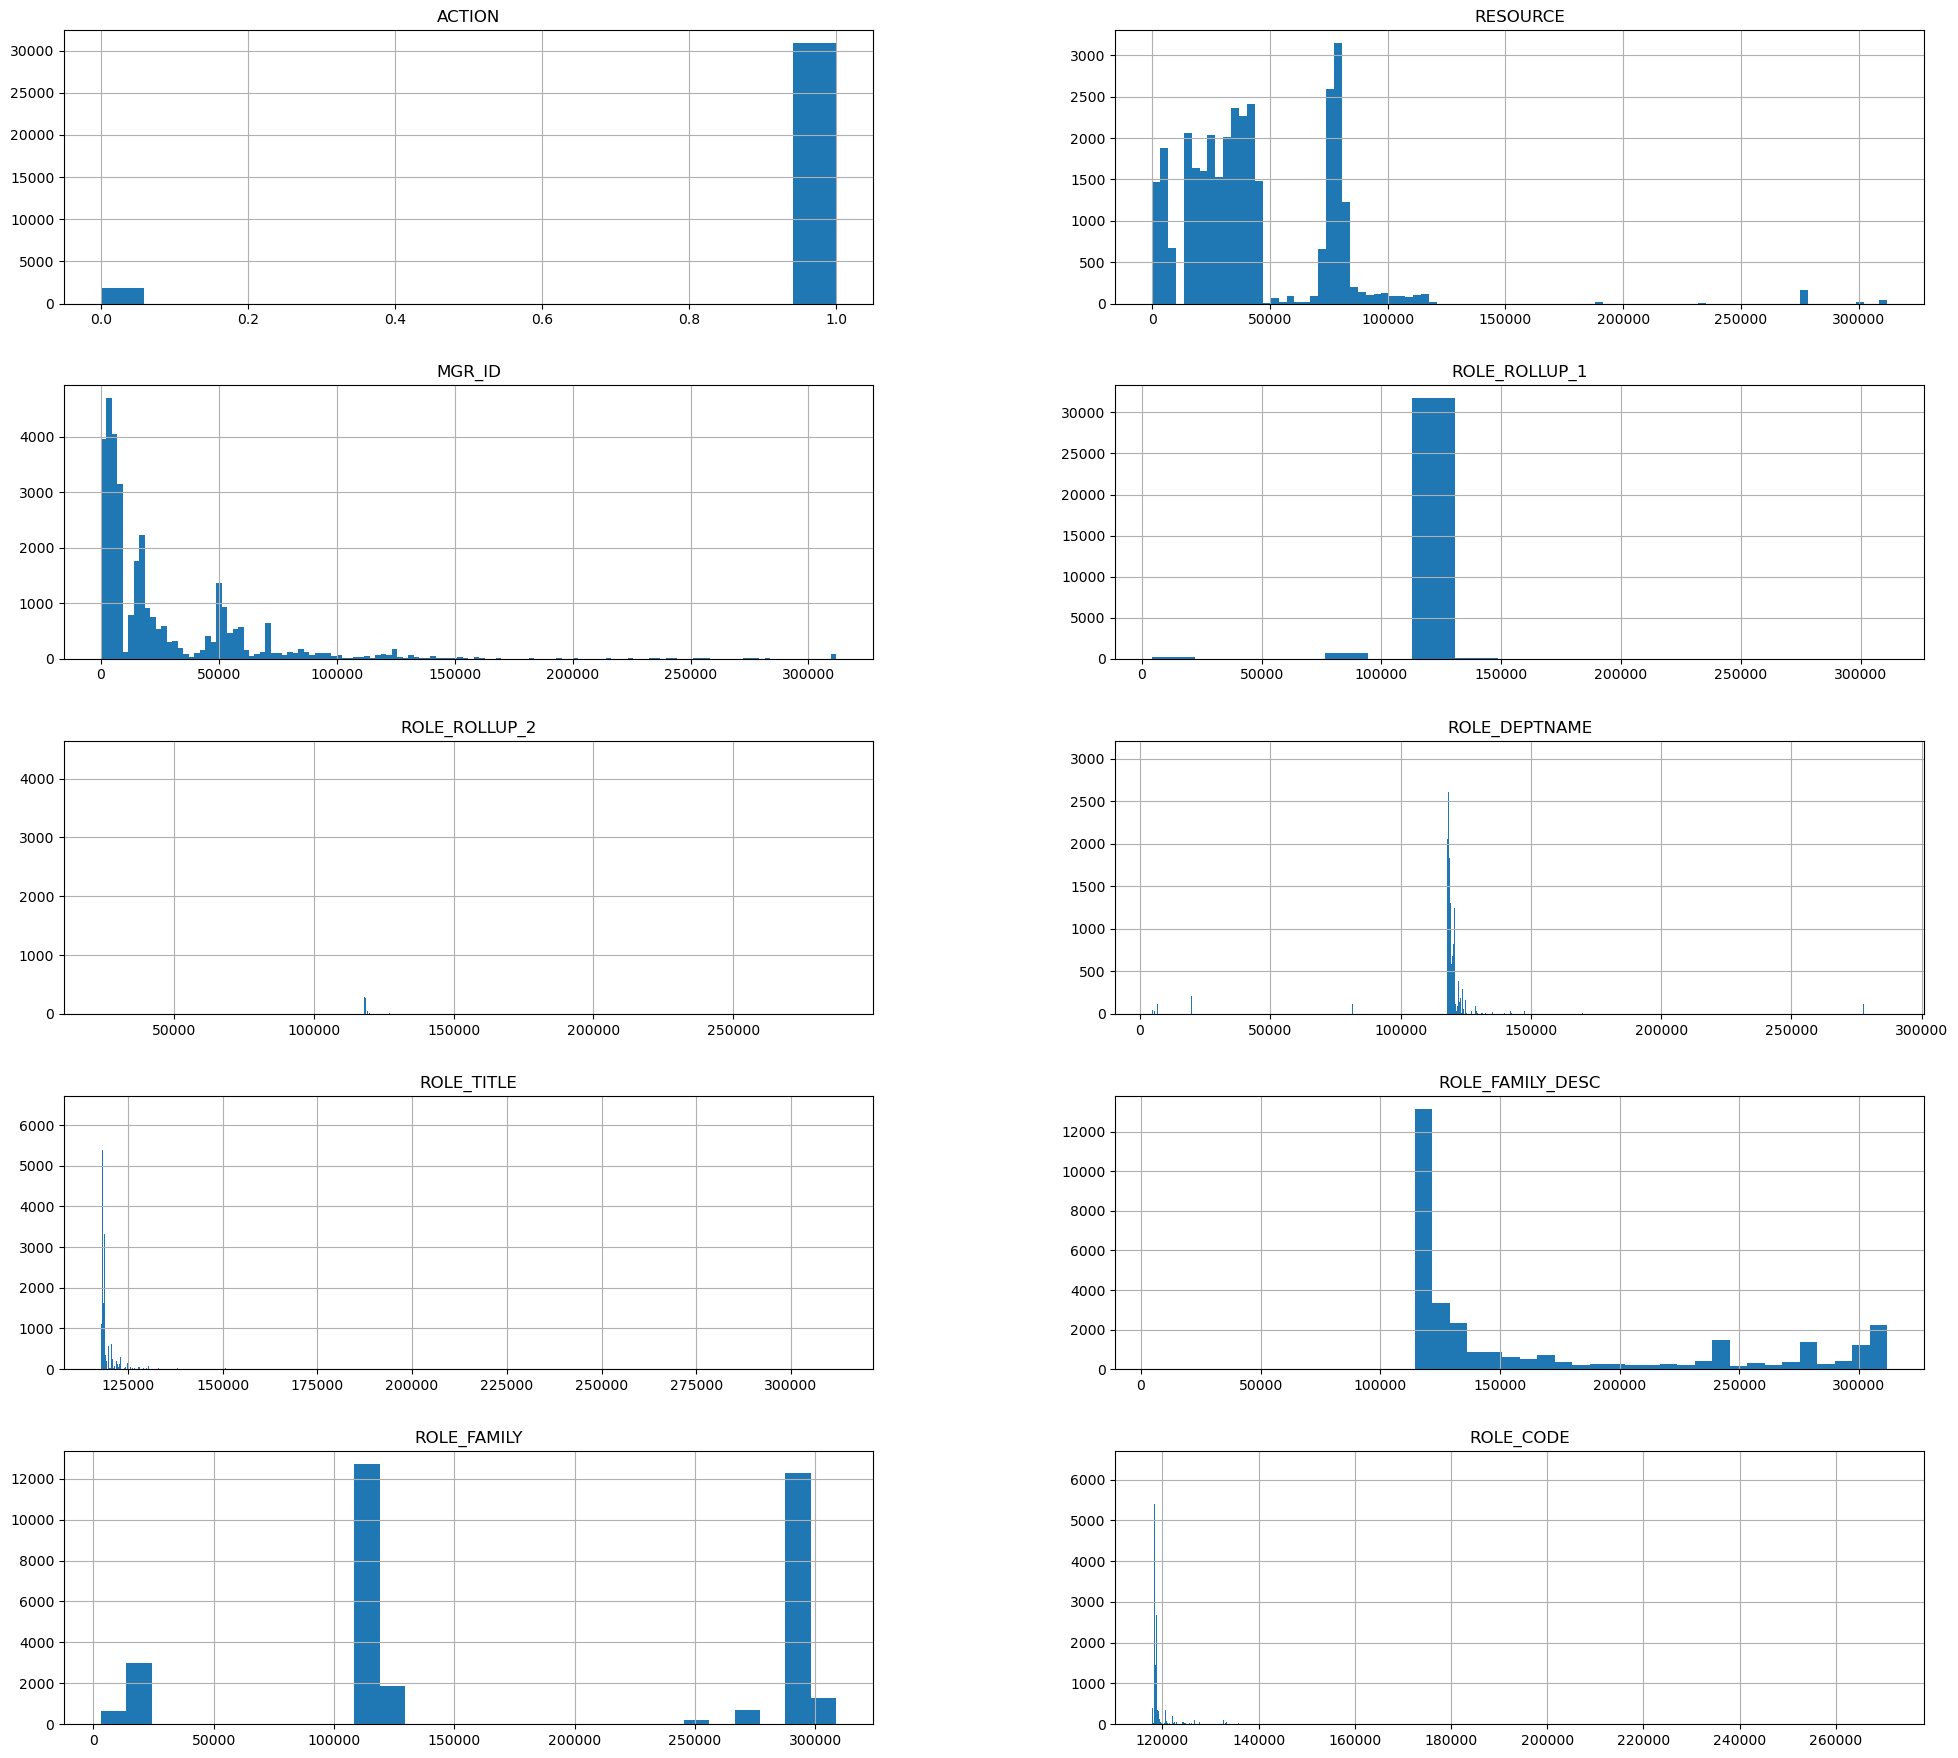

In [11]:
train.astype(int).hist(bins='auto', figsize=(24,22), layout=(5,2))

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'RESOURCE'}>],
       [<AxesSubplot:title={'center':'MGR_ID'}>,
        <AxesSubplot:title={'center':'ROLE_ROLLUP_1'}>],
       [<AxesSubplot:title={'center':'ROLE_ROLLUP_2'}>,
        <AxesSubplot:title={'center':'ROLE_DEPTNAME'}>],
       [<AxesSubplot:title={'center':'ROLE_TITLE'}>,
        <AxesSubplot:title={'center':'ROLE_FAMILY_DESC'}>],
       [<AxesSubplot:title={'center':'ROLE_FAMILY'}>,
        <AxesSubplot:title={'center':'ROLE_CODE'}>]], dtype=object)

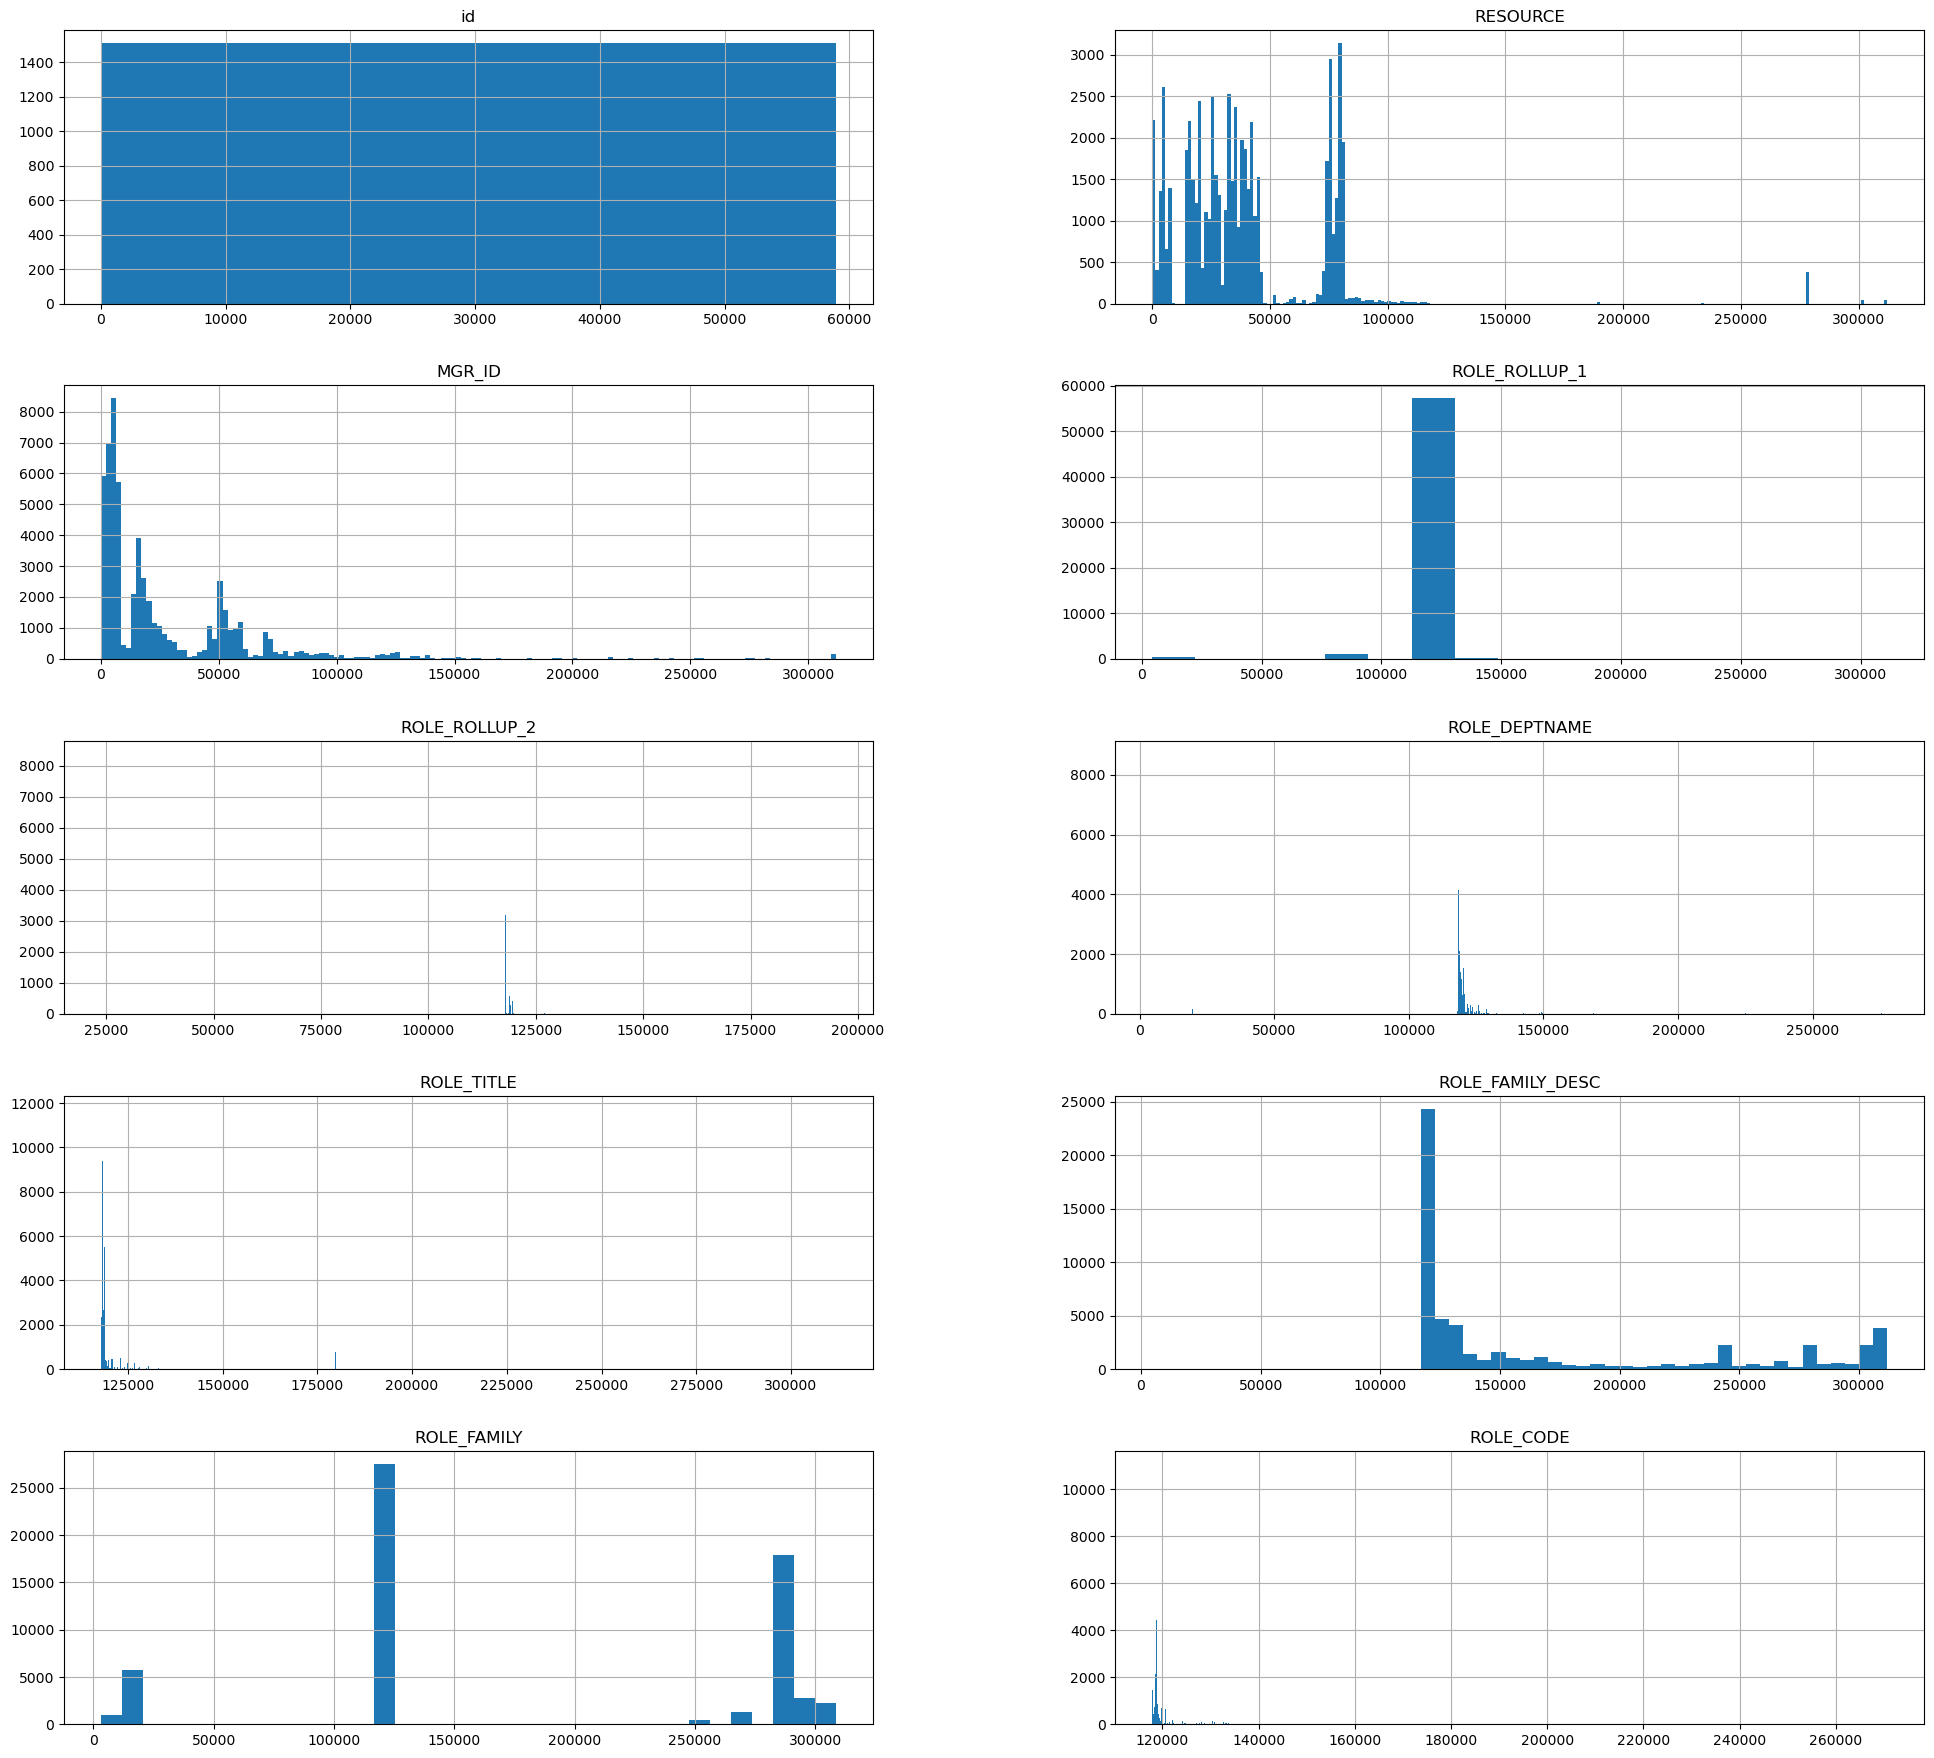

In [12]:
test.astype(int).hist(bins='auto', figsize=(24,22), layout=(5,2))

## Label Distribution

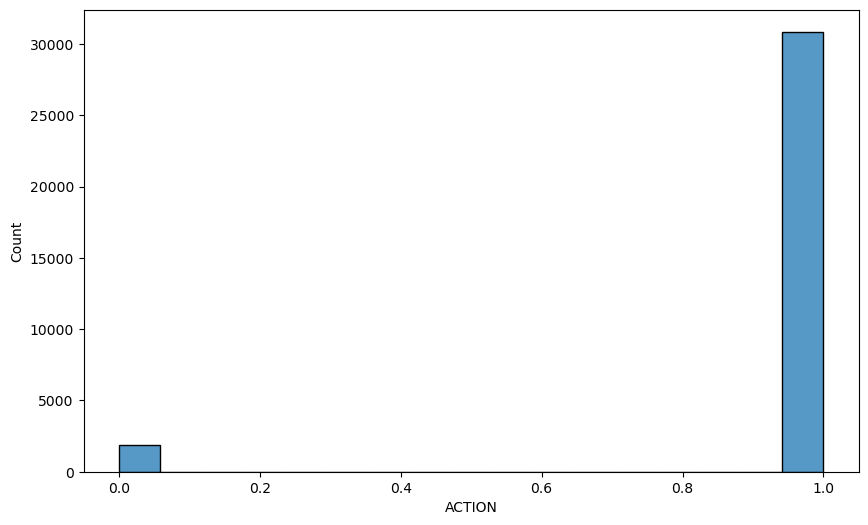

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(train["ACTION"], ax=ax)
plt.show()

## Null Value

In [14]:
train.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [15]:
test.isnull().sum()

id                  0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

## Correlation

<AxesSubplot:>

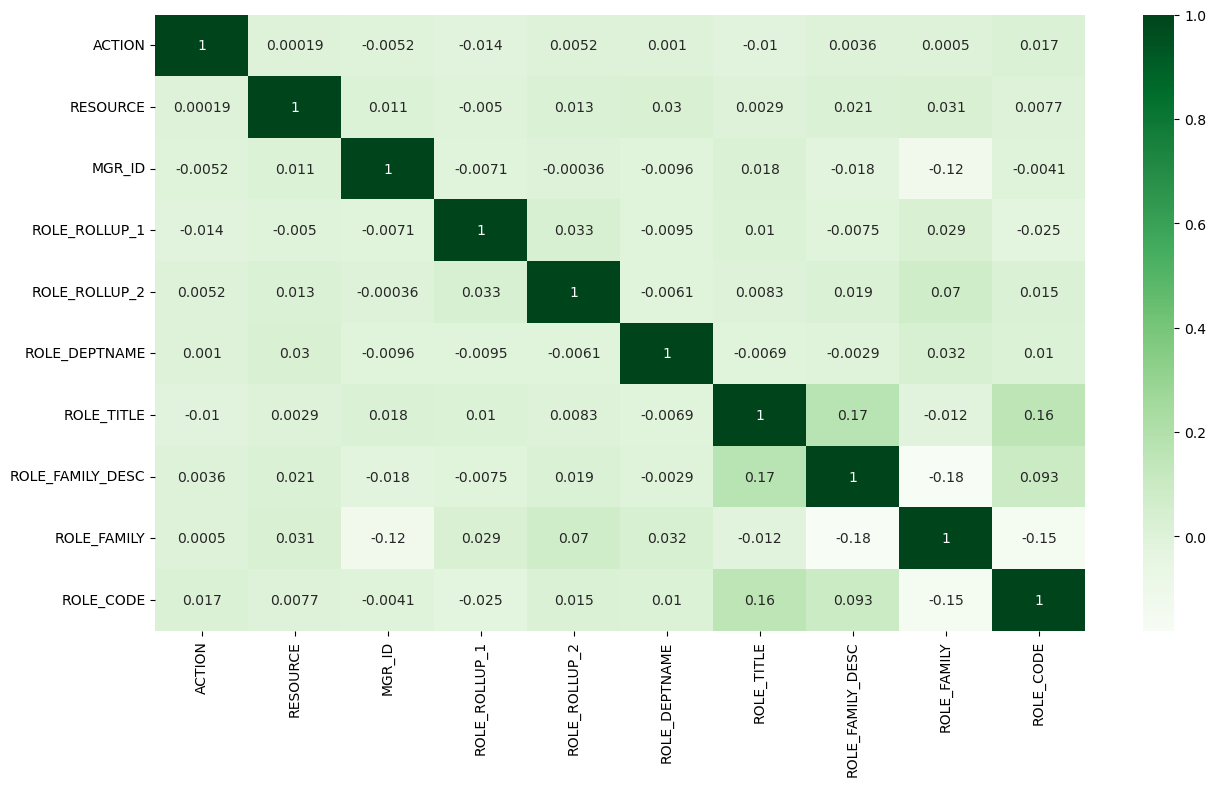

In [16]:
plt.figure(figsize=(15,8))
corr = train.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap= 'Greens')

## Feature Engineering

### One-Hot-Encoding

In [19]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown="ignore")
train_ohe = ohe.fit_transform(train.drop(columns=["ACTION","ROLE_TITLE","RESOURCE"]))
test_ohe = ohe.transform(test.drop(columns=["id","ROLE_TITLE","RESOURCE"]))

train_ohe.shape, test_ohe.shape

((32769, 7765), (58921, 7765))

## X, y

In [20]:
X = train_ohe
y = train["ACTION"]
X.shape, y.shape

((32769, 7765), (32769,))

## LGBM

In [23]:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [25]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0)

In [26]:
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'min_child_samples': Integer(1, 256),                # Minimal number of data in one leaf
    'max_bin': Integer(100, 1000),                       # Max number of bins that feature values will be bucketed
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(0, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'min_child_weight': Real(0.01, 10.0, 'uniform'),     # Minimum sum of instance weight (hessian) needed in a child (leaf)
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
    'scale_pos_weight': Real(1.0, 500.0, 'uniform'),     # Weighting of the minority class (Only for binary classification)
}

In [27]:
opt = BayesSearchCV(estimator=clf,                                    
                    search_spaces=search_spaces,                      
                    scoring=roc_auc,                                  
                    cv=skf,                                           
                    n_iter=3000,                                      # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

In [28]:
opt.fit(X,y)
print(opt.best_score_)
print(opt.best_params_)

KeyboardInterrupt: 

In [30]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                        #  **opt.best_params_
                        )

In [40]:
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
cvs

0.9454362147734529

In [41]:
clf.fit(X,y)

LGBMClassifier(metric='auc', n_jobs=1, objective='binary', random_state=0,
               verbose=-1)

In [42]:
clf

LGBMClassifier(metric='auc', n_jobs=1, objective='binary', random_state=0,
               verbose=-1)

In [43]:
file_name = f"{base_path}/submission{cvs}.csv"

In [44]:
submission = pd.DataFrame({'Id':test["id"], 'ACTION': clf.predict(test_ohe)})
submission.to_csv(file_name, index = False)

In [45]:
pd.read_csv(file_name).head()

,Id,ACTION
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
